In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 pip install -q tensorflow-model-optimization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow_model_optimization.python.core.keras.compat import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

data_dir = "/content/drive/MyDrive/New Folder/TinyML/Datasets/Tomatoes Diseases/"

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="training",
    seed=409,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 10288 files for training.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir + "Train",
    validation_split=0.2,
    subset="validation",
    seed=409,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 12860 files belonging to 10 classes.
Using 2572 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "Test",
    seed=409,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 3198 files belonging to 10 classes.


In [ ]:

class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mite_Two_spotted_sm',
 'Target_Spot',
 'Yellow_Leaf__Curl_Virus',
 'healthy',
 'mosaic_virus']

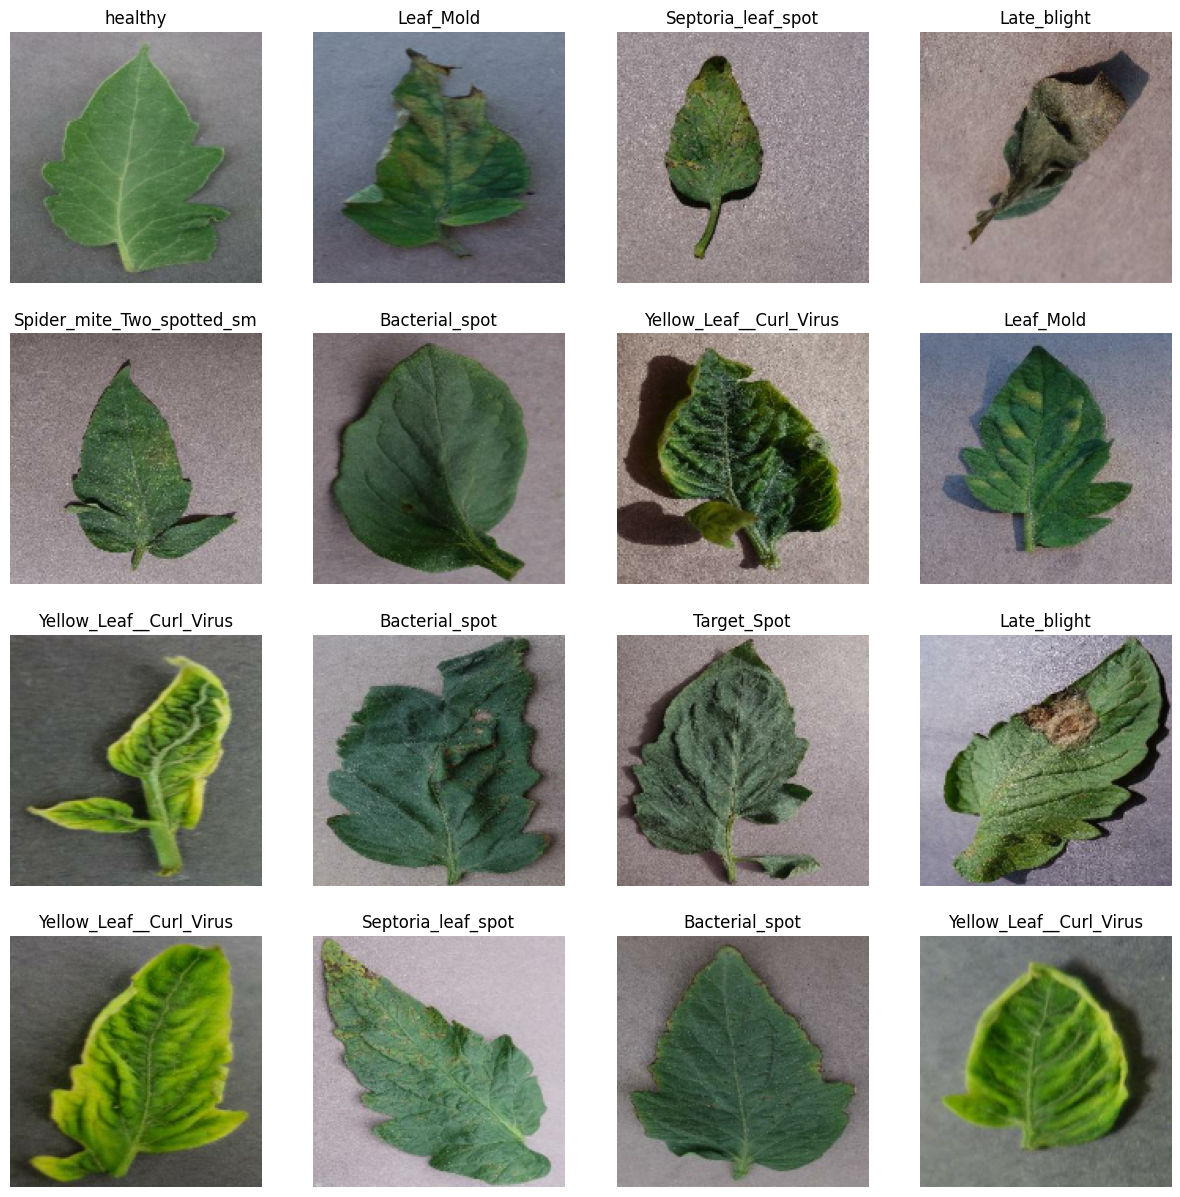

In [ ]:
plt.figure(figsize=(15, 15))
for img, lab in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[lab[i]])
        plt.axis("off")

In [ ]:
# set 8000 images for training and 1024 images for validation
train_nds = train_ds.take(125)
val_nds = val_ds.take(16)
test_nds = test_ds.take(16)

In [ ]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_nds = train_nds.cache().prefetch(buffer_size=AUTOTUNE)
val_nds = val_nds.cache().prefetch(buffer_size=AUTOTUNE)
test_nds = test_nds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

base_model = keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = base_model(x, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10)(x)
MobileNet = keras.Model(inputs, outputs)

In [ ]:
MobileNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [ ]:
MobileNet.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [17]:
history = MobileNet.fit(
    train_nds,
    validation_data=val_nds,
    epochs=50,
)

Epoch 1/50
125/125 [==============================] - 3582s 28s/step - loss: 1.8109 - accuracy: 0.4022 - val_loss: 1.1696 - val_accuracy: 0.6670
Epoch 2/50
125/125 [==============================] - 34s 270ms/step - loss: 0.9341 - accuracy: 0.7308 - val_loss: 0.7423 - val_accuracy: 0.7891
Epoch 3/50
125/125 [==============================] - 33s 264ms/step - loss: 0.5961 - accuracy: 0.8345 - val_loss: 0.5394 - val_accuracy: 0.8398
Epoch 4/50
125/125 [==============================] - 33s 263ms/step - loss: 0.4212 - accuracy: 0.8894 - val_loss: 0.4223 - val_accuracy: 0.8691
Epoch 5/50
125/125 [==============================] - 33s 267ms/step - loss: 0.3118 - accuracy: 0.9234 - val_loss: 0.3492 - val_accuracy: 0.8896
Epoch 6/50
125/125 [==============================] - 33s 266ms/step - loss: 0.2376 - accuracy: 0.9455 - val_loss: 0.3018 - val_accuracy: 0.9053
Epoch 7/50
125/125 [==============================] - 33s 266ms/step - loss: 0.1851 - accuracy: 0.9591 - val_loss: 0.2668 - val_ac

In [18]:
def plot_curves(his):

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    accuracy = his.history['accuracy']
    val_accuracy = his.history['val_accuracy']

    epochs = range(len(his.history['loss']))

    # ploting the loss
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

    # ploting the accuracy
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()


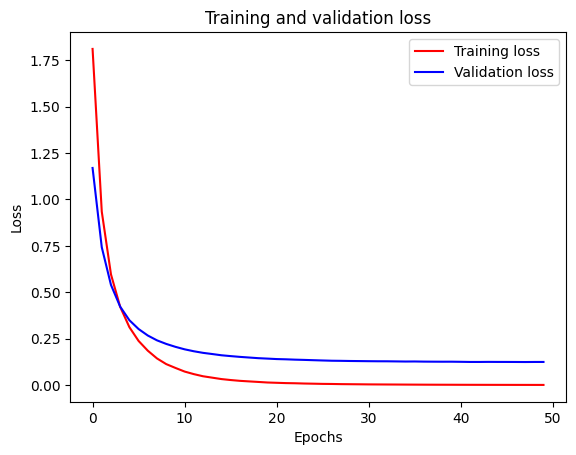

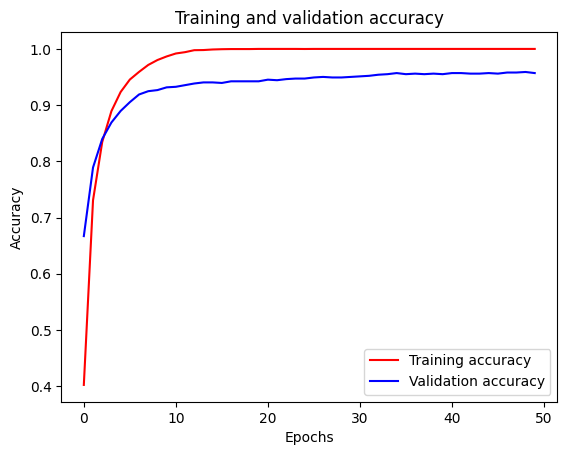

<Figure size 640x480 with 0 Axes>

In [19]:
plot_curves(history)

In [ ]:
klkl

In [22]:
# saving the model to the disk

model_name = "/content/drive/MyDrive/New Folder/TinyML/SaveModels/MobileNet.h5"
keras.models.save_model(MobileNet, model_name, include_optimizer=False)


<ipython-input-22-23be74ce476d>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(MobileNet, model_name, include_optimizer=False)


In [21]:
loss, acc = MobileNet.evaluate(test_nds)
print("Accuracy", acc)
print("Loss", loss)

16/16 [==============================] - 578s 24s/step - loss: 0.1711 - accuracy: 0.9551
Accuracy 0.955078125
Loss 0.17114126682281494


In [24]:
# Get predictions
y_pred = MobileNet.predict(test_nds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_nds], axis=0)

# Compute confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred)

16/16 [==============================] - 3s 89ms/step


In [25]:
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[133,   0,   0,   0,   0,   0,   2,   1,   0,   0],
       [  0,  47,   5,   0,   6,   0,   3,   0,   0,   1],
       [  0,   2, 131,   3,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  55,   1,   1,   0,   0,   0,   0],
       [  1,   6,   0,   2,  95,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0, 102,   2,   0,   0,   1],
       [  0,   0,   1,   0,   4,   0,  88,   0,   0,   0],
       [  1,   0,   0,   0,   1,   0,   0, 205,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  99,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  23]], dtype=int32)>

Text(0.5, 1.0, 'Confusion Matrix')

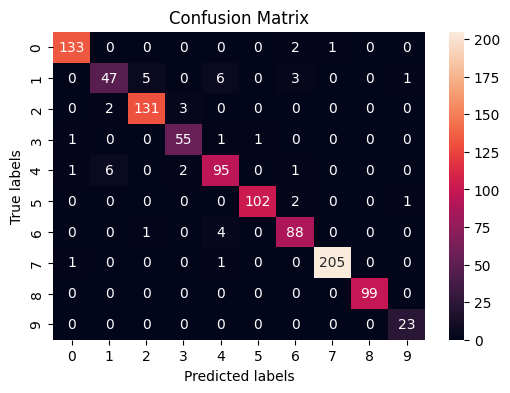

In [26]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

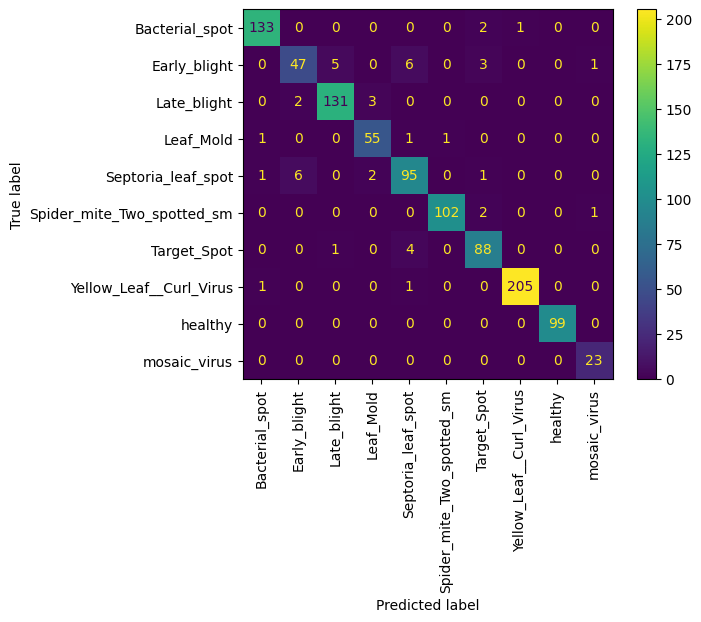

In [27]:
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=class_names, xticks_rotation='vertical'
)

In [28]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Accuracy", acc)
print("Loss", loss)

Precision: 0.9415311704405023
Recall: 0.9460282048367702
F1 Score: 0.9432552317322536
Accuracy 0.955078125
Loss 0.17114126682281494
